In [307]:
import tensorflow as tf ### models
import numpy as np ### math computations
import matplotlib.pyplot as plt ### plotting bar chart
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from google.colab import drive

## Data Preparation

###Data Loading

In [315]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

In [316]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset



In [317]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

#dataset = tf.data.Dataset.range(10)

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [318]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(121, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [319]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [320]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

## Dataset Visualization

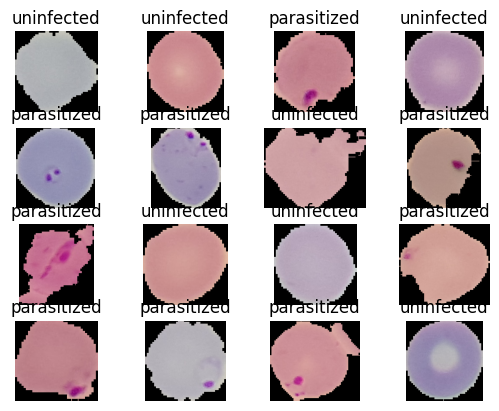

In [321]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [121]:
#for i, (image, label) in enumerate(train_dataset.take(2)):
#  plt.subplot(1, 4, 2*i + 1)
#  plt.imshow(image)
#  plt.subplot(1, 4, 2*i + 2)
#  plt.imshow(tf.image.adjust_saturation(image, 0.3))

#  plt.title(dataset_info.features['label'].int2str(label))
#  plt.axis('off')

## Data Preprocessing

### Data augmentation

In [322]:
def visualize(original, augmented):
  plt.subplot(1, 2, 1)
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.imshow(augmented)


In [323]:
original_image, label = next(iter(train_dataset))

In [324]:
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor= 0.3)

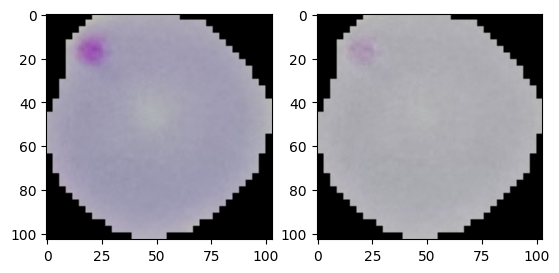

In [325]:
visualize(original_image, augmented_image)

In [326]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [327]:
### tf.image augment
def augment(image, label):

  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))
  #image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  #image = tf.image.stateless_random_saturation(image, 0.3, 0.5)
  image = tf.image.stateless_random_flip_left_right(image)

  return image, label

In [328]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()

  def call(self, image):
    return tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))

In [329]:
### tf.keras.layer resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255),
])

In [330]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
    RotNinety(),
    RandomFlip(mode='horizontal'),
])

def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

In [238]:
#train_dataset = train_dataset.map(augment)
#val_dataset = val_dataset.map(resize_rescale_layers)
#test_dataset = test_dataset.map(resize_rescale_layers)

In [331]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(151, 115, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [332]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
   ## .map(augment_layer)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE))

In [333]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    ##.map(resize_rescale_layers)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE))

In [334]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [335]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model Creation

### Sequential API

In [336]:
IM_SIZE = 224
dropout_rate = 0.3
regularization_rate = 0.01
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),

    resize_rescale_layers,
    augment_layers,

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding="valid", activation = 'relu', kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    Dropout(rate = dropout_rate),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding="valid", activation = 'relu', kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),
    Dense(100, activation = "relu", kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),

    Dense(10, activation = "relu", kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    Dense(1, activation = "sigmoid")

])

lenet_model.summary()



Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_29 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 sequential_30 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_72 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 111, 111, 6)     

### Functional API

In [137]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding="valid", activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding="valid", activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2)(x)


feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_34 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_35 (Ba  (None, 109, 109, 16)

In [138]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding="valid", activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding="valid", activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),


])

feature_extractor_seq_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_36 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_37 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

### Callable Model

In [139]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_8 (Flatten)         (None, 46656)             0         
                                                                 
 dense_21 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_38 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_22 (Dense)            (None, 10)                1010      
                                                       

### Model Subclassing

In [140]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 =  Conv2D(filters = filters, kernel_size=kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

    self.conv_2 =  Conv2D(filters = filters*2, kernel_size=kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [141]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_2 (Featu  (None, 54, 54, 16)        1488      
 reExtractor)                                                    
                                                                 
 flatten_9 (Flatten)         (None, 46656)             0         
                                                                 
 dense_24 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_42 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 10)                

In [142]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor =  FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x  = self.batch_1(x)
    x = self.dense_2(x)
    x  = self.batch_2(x)
    x = self.dense_3(x)

    return x
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1, 224, 224, 3]))
lenet_sub_classed.summary()

Model: "lenet_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_3 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_10 (Flatten)        multiple                  0         
                                                                 
 dense_27 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_46 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_28 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_47 (Ba  multiple                

### Custom Layers

In [143]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self,input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape= (self.output_units,), initializer = "random_normal", trainable = True)


  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b
    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)
    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output

IM_SIZE = 224
letnet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding="valid", activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding="valid", activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    NeuralearnDense(100, activation = "relu"),
    BatchNormalization(),

    NeuralearnDense(10, activation = "relu"),
    BatchNormalization(),
    NeuralearnDense(1, activation = "sigmoid")

])

letnet_custom_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_48 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_49 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

## Callbacks

In [144]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

### CSVLogger

In [145]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

### EarlyStoping

In [146]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

### LearningRateScheduler

In [147]:
def scheduler(epoch, lr):

  if epoch <= 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

###ModelCheckpointing

In [148]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_precision', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch',
)

###ReduceLearningRateOnPlateau

In [149]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1
)

## Model Training

In [150]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [268]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [337]:
lenet_model.compile(optimizer = Adam(learning_rate=0.01),
                         loss=BinaryCrossentropy(),
                         metrics= metrics
                        # run_eagerly=True    #----> ativate this for make the model more debugable
                    )

In [303]:
lenet_sub_classed.compile(optimizer = Adam(learning_rate = 0.01),
              loss=BinaryCrossentropy(),
              metrics = 'accuracy')

In [ ]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs = 5, verbose = 1)

Epoch 1/5
22046/22046 [==============================] - 258s 12ms/step - loss: 0.6991 - tp: 7183.0000 - fp: 7157.0000 - tn: 6498.0000 - fn: 6519.0000 - accuracy: 0.5001 - precision: 0.5009 - recall: 0.5242 - auc: 0.4991 - val_loss: 0.6972 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1365.0000 - val_fn: 1390.0000 - val_accuracy: 0.4955 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/5
22046/22046 [==============================] - 248s 11ms/step - loss: 0.6985 - tp: 5463.0000 - fp: 5412.0000 - tn: 5611.0000 - fn: 5560.0000 - accuracy: 0.5023 - precision: 0.5023 - recall: 0.4956 - auc: 0.4991 - val_loss: 0.6971 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1367.0000 - val_fn: 1388.0000 - val_accuracy: 0.4962 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/5
22046/22046 [==============================] - 248s 11ms/step - loss: 0.6984 - tp: 5436.0000 - fp: 5457.0000 - tn: 5567.0000 - fn: 5586.0000 - accuracy: 0.499

In [ ]:
history_func = lenet_model_func.fit(train_dataset, validation_data=val_dataset, epochs = 20, verbose = 1)

In [312]:
image = cv2.imread('cell.jpg')
print(image.shape)
image = tf.expand_dims(image, axis=0)
print(image.shape)

lenet_model.predict(image)

(130, 136, 3)
(1, 130, 136, 3)
1/1 [==============================] - 0s 17ms/step


array([[0.5017297]], dtype=float32)

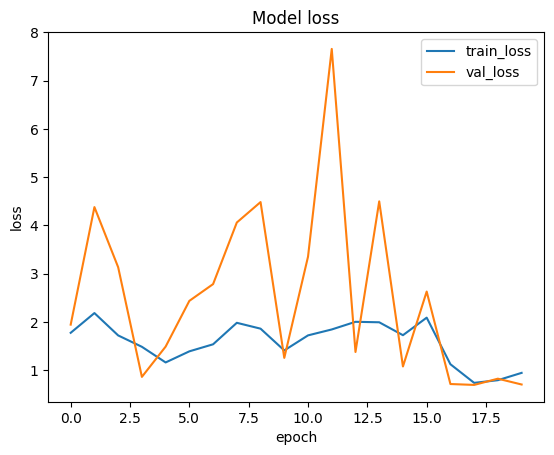

In [110]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

## Model Evaluation and Testing

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
letnet_model.evaluate(test_dataset)

2757/2757 [==============================] - 21s 4ms/step - loss: 4.0646 - accuracy: 0.5049


[4.064562797546387, 0.5048966407775879]

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(letnet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 11s 11s/step


'P'

1/1 [==============================] - 0s 21ms/step


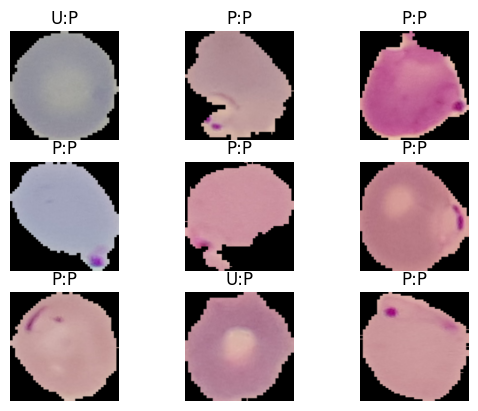

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(letnet_model.predict(image)[0][0])))

  plt.axis('off')

## Visualizing Confusion Matrix

In [ ]:
labels = []
inp = []

for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:, 0, ...].shape)

In [ ]:
labels = np.array([i[0] for i in labels])

In [ ]:
print(labels)

In [ ]:
predicted = lenet_model.predict(np.array(inp)[:, 0, ...])
print(predicted[:,0])

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True)
plt.title('Confusion matrix- {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

## ROC Plots

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
# print(len(fp), len(tp), len(thresholds))
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip)
 plt.test(fp[i], tp[i], thresholds[i])
plt.show()

## Loading and Saving

In [ ]:
letnet_model.save("lenet")

In [ ]:
letnet_loaded_model = tf.keras.models.load_model("lenet")
letnet_loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

1/1 [==============================] - 0s 35ms/step


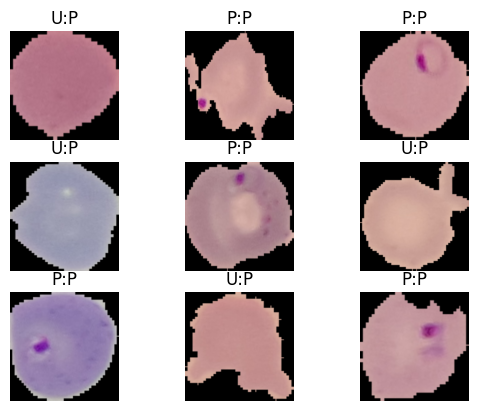

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(letnet_loaded_model.predict(image)[0][0])))

  plt.axis('off')

In [ ]:
letnet_loaded_model.evaluate(test_dataset)

2757/2757 [==============================] - 22s 4ms/step - loss: 4.0915 - accuracy: 0.5034


[4.091502666473389, 0.5034458041191101]

In [ ]:
letnet_model.save("lenet.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
lenet_loaded_model_hdf5 = tf.keras.models.load_model("lenet.hdf5")
lenet_loaded_model_hdf5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [ ]:
letnet_model.save_weights("weights/lenet_weights")

In [ ]:
letnet_weights_model = letnet_model.load_weights("weights/lenet_weights")

In [ ]:
letnet_model.load_weights("weights/lenet_weights")
letnet_model.evaluate(test_dataset)

2757/2757 [==============================] - 21s 4ms/step - loss: 4.0475 - accuracy: 0.5063


[4.047532558441162, 0.5063474774360657]

## Saving to Google Drive

In [ ]:
#drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#!cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab

In [ ]:
#!cp -r /content/drive/MyDrive/lenet_colab /content/lenet_colab/